In [136]:
%load_ext autoreload 
%autoreload 2
import sys
from os import path
import glob
import pandas as pd
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from comet_ml import API
sys.path.append("..")
from src import config
sb.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path_to_test="../test_report"
task_hue_order=('SSIM', 'MOTION', 'BINARY')
api = API(config.COMET_API_KEY)


In [4]:
def ms_to_time(millis:int):
    seconds = millis // 1000
    minutes = seconds // 60
    hours = minutes // 60
    minutes = minutes % 60
    return int(hours), int(minutes)

def get_duration_df_pretrain(experiments):
    durations = []
    for exp in experiments:
        ms = (exp.get_metadata()['durationMillis'])
        model = exp.get_parameters_summary("model_class")['valueMax']
        task = exp.get_parameters_summary("task")['valueMax']
        hours, minutes = ms_to_time(ms)
        durations.append((model, task, hours, minutes, f"{hours}:{str(minutes).zfill(2)}"))
    return pd.DataFrame(durations, columns=("model", "task", "hours", "minutes", "duration"))

def get_compute_usage_df(experiments, task_dependent=False):
    durations = []
    for exp in experiments:
        ms = (exp.get_metadata()['durationMillis'])
        model = exp.get_parameters_summary("model")['valueMax']
        
        hours, minutes = ms_to_time(ms)
        gpu_memory = float(exp.get_metrics_summary("sys.gpu.0.used_memory")['valueMax'])/1e9
        gpu_power_usage = float(exp.get_metrics_summary("sys.gpu.0.power_usage")['valueMax'])/1000

        if task_dependent:
            _,_,_,task,_ = exp.name.split('-')
            durations.append((model, task,ms, hours, minutes, f"{hours}:{str(minutes).zfill(2)}", gpu_memory, gpu_power_usage))
        else: 
            durations.append((model,ms, hours, minutes, f"{hours}:{str(minutes).zfill(2)}", gpu_memory, gpu_power_usage))

    if task_dependent:
        columns = ("model", "task", "millis", "hours", "minutes", "duration", "max_gpu_ram_used", "max_gpu_power_usage")
    else: 
        columns = ("model", "millis","hours", "minutes", "duration", "max_gpu_ram_used", "max_gpu_power_usage")

    return pd.DataFrame(durations, columns=columns)

# Testing Pretrained Models

## Output from test procedure

First we will aggregate the results csv obtained on each pretrained model when running `cli.py test pretrain`

In [5]:
motion_res = []
ssim_res = []
binary_res= []

mrart_results=[]
for models_directory in glob.glob(path.join(path_to_test,"pretraining", "*")):
    model, task, *_ = path.basename(models_directory).split("-")

    results = pd.read_csv(path.join(models_directory, "results.csv"))
    results['model']=model
    results['task']=task
    if task=="MOTION":
        motion_res.append(results[['model', 'task','source','r2','rmse']])
    elif task=="SSIM":
        ssim_res.append(results[['model', 'task','source','r2','rmse']])
    elif task=="BINARY":
        binary_res.append(results[['model', 'task','source','balanced_accuracy','rmse']])

    mrart = pd.read_csv(path.join(models_directory, 'mrart_recap.csv'))
    mrart['model']=model
    mrart['task']=task
    mrart_results.append(mrart[['model', 'task', 'balanced_accuracy','threshold_1','threshold_2','f1_0','f1_1','f1_2']])

motion_res =pd.concat(motion_res)
ssim_res =pd.concat(ssim_res)
binary_res =pd.concat(binary_res)

motion_res= motion_res[motion_res['source']=='simple']
ssim_res= ssim_res[ssim_res['source']=='simple']
binary_res= binary_res[binary_res['source']=='simple']

thresh_mrart_results =pd.concat(mrart_results)
exps = api.get_experiments("mrart", "estimate-motion-pretrain", "pretraining-*")
duration_df = get_duration_df_pretrain(exps)

### Analysis of motion results

Text(0.5, 1.0, 'Root mean squared error test results')

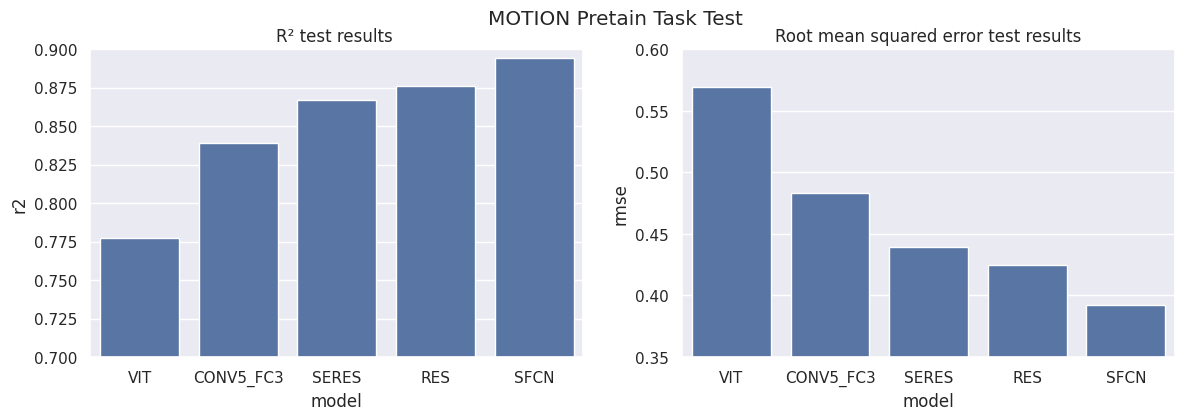

In [144]:
fig=plt.figure(figsize=(14,4))
fig.suptitle("MOTION Pretain Task Test")

plt.subplot(1,2,1)
sb.barplot(motion_res.sort_values("r2"), x="model", y="r2")
plt.ylim((0.7,0.9))
plt.title("R² test results ")


plt.subplot(1,2,2)
sb.barplot(motion_res.sort_values("rmse", ascending=False), x="model", y="rmse")
plt.ylim((0.35,0.6))
plt.title("Root mean squared error test results")


### Analysis of SSIM results

Text(0.5, 1.0, 'Root mean squared error results')

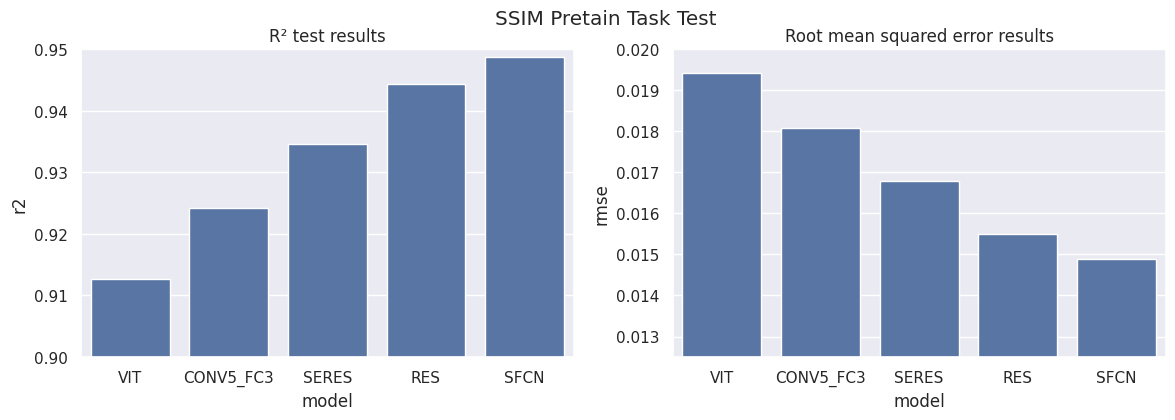

In [145]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("SSIM Pretain Task Test")
plt.subplot(1,2,1)
sb.barplot(ssim_res.sort_values("r2"), x="model",  y="r2")
plt.ylim((0.9,0.95))
plt.title("R² test results")


plt.subplot(1,2,2)
sb.barplot(ssim_res.sort_values("rmse", ascending=False), x="model", y="rmse")
plt.ylim((0.0125,0.02))
plt.title("Root mean squared error results")

### Analysis of BINARY results

Text(0.5, 1.0, 'Root mean squared error results')

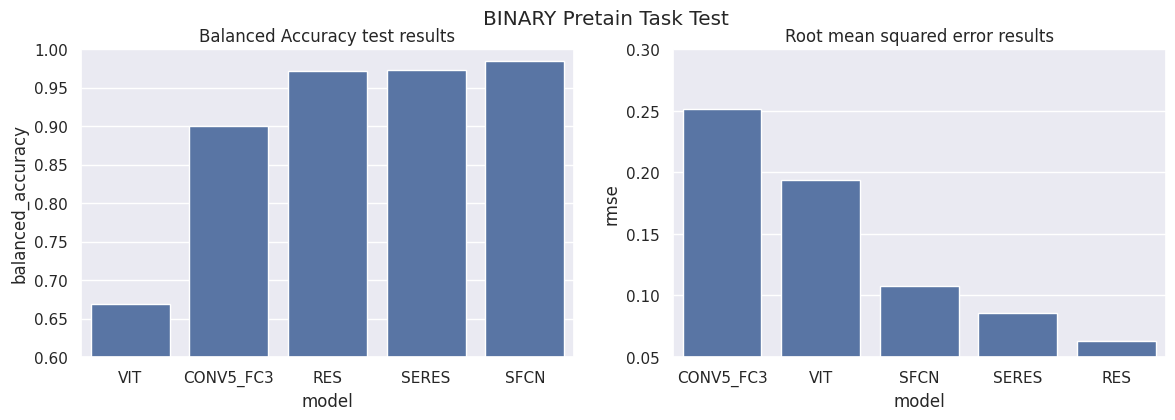

In [146]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("BINARY Pretain Task Test")

plt.subplot(1,2,1)
sb.barplot(binary_res.sort_values("balanced_accuracy"), x="model", y="balanced_accuracy")
plt.ylim((0.6,1))
plt.title("Balanced Accuracy test results")

plt.subplot(1,2,2)
sb.barplot(binary_res.sort_values("rmse", ascending=False), x="model", y="rmse")
plt.ylim((0.05,0.3))
plt.title("Root mean squared error results")


### Overall pretraining performances analysis

In [9]:
select_col = ['model', 'rank']
sorted_motion = motion_res.sort_values("r2", ascending=False)
sorted_motion['rank'] = range(1,6)
sorted_motion= sorted_motion[select_col]

sorted_ssim = ssim_res.sort_values("r2", ascending=False)
sorted_ssim['rank'] = range(1,6)
sorted_ssim= sorted_ssim[select_col]

sorted_binary = binary_res.sort_values("balanced_accuracy", ascending=False)
sorted_binary['rank'] = range(1,6)
sorted_binary= sorted_binary[select_col]

sorted_ranked = pd.concat([sorted_motion, sorted_ssim, sorted_binary]).groupby("model").agg(['mean', lambda x: str(list(x))]).sort_values(('rank','mean'))
sorted_ranked

rank           
               mean <lambda_0>
model                         
SFCN       1.000000  [1, 1, 1]
RES        2.333333  [2, 2, 3]
SERES      2.666667  [3, 3, 2]
CONV5_FC3  4.000000  [4, 4, 4]
VIT        5.000000  [5, 5, 5]

### Analysis of MR-ART predictions

Now let's test how it perform on the MR-ART dataset, we trained a two threshold classifier on our pretrained network output to assess correlation of the network output and MR-ART classes with simple threshold based decision

Text(0.5, 1.0, 'Average Balanced Accuracy By Task for Threshold Models')

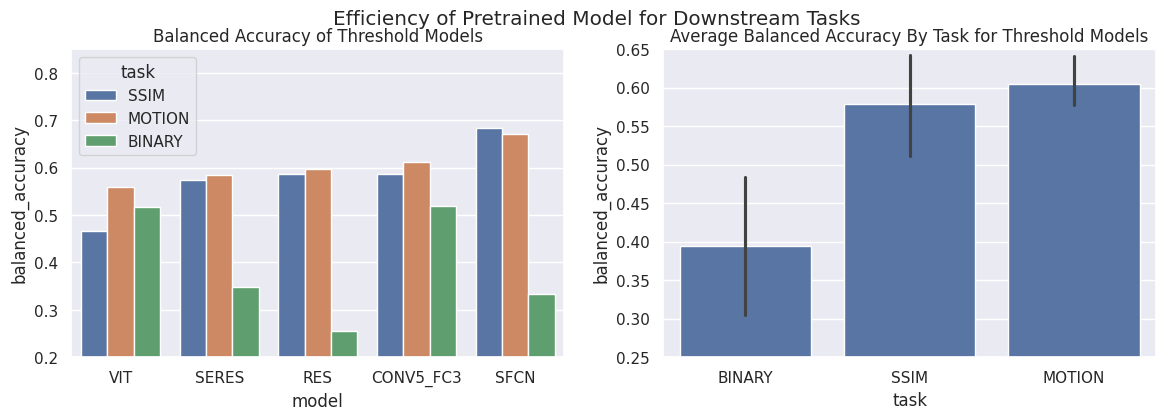

In [147]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("Efficiency of Pretrained Model for Downstream Tasks")
plt.subplot(1,2,1)
sb.barplot(thresh_mrart_results, x="model", y="balanced_accuracy", hue="task", hue_order=task_hue_order, order=[
   'VIT',    'SERES','RES','CONV5_FC3', 'SFCN',
])
plt.ylim((0.2,0.85))
plt.title("Balanced Accuracy of Threshold Models")

plt.subplot(1,2,2)
sb.barplot(thresh_mrart_results.sort_values("balanced_accuracy"), x="task",  y="balanced_accuracy")
plt.ylim((0.25,0.65))
plt.title("Average Balanced Accuracy By Task for Threshold Models")

Let's delve a bit into each classes f1 score for each scenario :

Text(0.5, 1.0, 'Class 2')

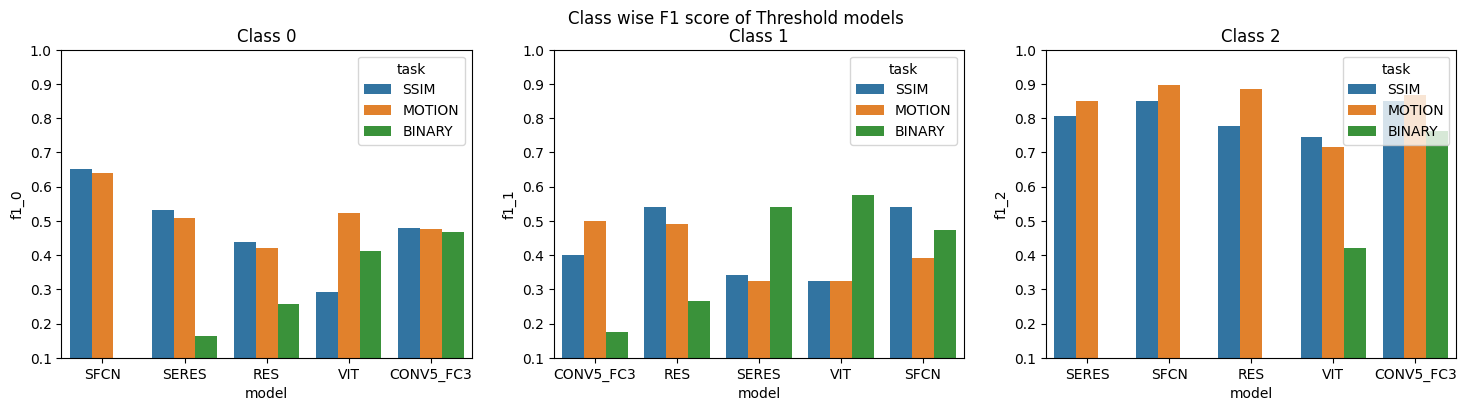

In [11]:
fig=plt.figure(figsize=(18,4))
fig.suptitle("Class wise F1 score of Threshold models")
plt.subplot(1,3,1)
sb.barplot(thresh_mrart_results.sort_values("f1_0"), x="model", y="f1_0",hue="task", hue_order=task_hue_order)
plt.ylim((0.1,1))
plt.title("Class 0")

plt.subplot(1,3,2)
sb.barplot(thresh_mrart_results.sort_values("f1_1"), x="model",  y="f1_1",hue="task", hue_order=task_hue_order)
plt.ylim((0.1,1))
plt.title("Class 1")

plt.subplot(1,3,3)
sb.barplot(thresh_mrart_results.sort_values("f1_2"), x="model",  y="f1_2",hue="task", hue_order=task_hue_order)
plt.ylim((0.1,1))
plt.title("Class 2")

In [12]:
to_report = thresh_mrart_results.sort_values("balanced_accuracy", ascending=False).iloc[:10]
to_report = to_report.drop(columns=["threshold_1", "threshold_2"])
print(to_report.to_latex(escape=True, index=False,  float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
model & task & balanced\_accuracy & f1\_0 & f1\_1 & f1\_2 \\
\midrule
SFCN & SSIM & 0.684 & 0.651 & 0.542 & 0.851 \\
SFCN & MOTION & 0.670 & 0.640 & 0.390 & 0.897 \\
CONV5\_FC3 & MOTION & 0.612 & 0.476 & 0.500 & 0.868 \\
RES & MOTION & 0.597 & 0.421 & 0.492 & 0.886 \\
CONV5\_FC3 & SSIM & 0.587 & 0.478 & 0.400 & 0.851 \\
RES & SSIM & 0.586 & 0.437 & 0.541 & 0.778 \\
SERES & MOTION & 0.585 & 0.509 & 0.326 & 0.850 \\
SERES & SSIM & 0.573 & 0.531 & 0.340 & 0.805 \\
VIT & MOTION & 0.560 & 0.523 & 0.326 & 0.714 \\
CONV5\_FC3 & BINARY & 0.519 & 0.467 & 0.176 & 0.762 \\
\bottomrule
\end{tabular}



## Training From Scratch

In [150]:
full_results = []
conf_results=[]
for models_directory in glob.glob(path.join(path_to_test,"scratch", "*")):
    model, run_num = path.basename(models_directory).removesuffix('.ckpt').split("-")

    results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
    results['model']=model
    results['run_num']=int(run_num)

    conf_df = pd.read_csv(path.join(models_directory, "confidence.csv"))
    row_95 = conf_df[conf_df['threshold_confidence']>0.949].iloc[0]
    conf_results.append([model, int(run_num), 'conf-95',row_95['balanced_accuracy'], row_95['kept_proportion']])
    row_99 = conf_df[conf_df['threshold_confidence']>0.989].iloc[0]
    conf_results.append([model, int(run_num), 'conf-99',row_99['balanced_accuracy'], row_99['kept_proportion']])

    full_results.append(results[['model', 'run_num','source','balanced_accuracy','f1_0','f1_1','f1_2']])

full_results =pd.concat(full_results)
scratch_averaged_res = full_results.groupby(["model","source"], as_index=False).agg(['mean', 'std', 'max'])
scratch_averaged_res.columns = ['_'.join(col).strip().strip("_") for col in scratch_averaged_res.columns.values]
simple_scratch = full_results[full_results['source']=='simple']

conf_results = pd.DataFrame(conf_results, columns=['model',  'run_num', 'source','balanced_accuracy','kept_proportion'])
full_results['kept_proportion']=1
conf_results = pd.concat([conf_results,full_results[['model', 'run_num', 'source','balanced_accuracy','kept_proportion']]])
conf_results = conf_results[conf_results['source']!='mcdropout']

exps = api.get_experiments("mrart", "baseline-mrart")
scratch_ressources_df = get_compute_usage_df(exps)
conf_results

,model,run_num,source,balanced_accuracy,kept_proportion
0,CONV5_FC3,2,conf-95,1.000000,0.235955
1,CONV5_FC3,2,conf-99,1.000000,0.168539
2,RES,3,conf-95,1.000000,0.191011
3,RES,3,conf-99,1.000000,0.056180
4,SERES,5,conf-95,0.666667,0.449438
...,...,...,...,...,...
0,VIT,3,simple,0.763668,1.000000
0,RES,5,simple,0.670882,1.000000
0,SFCN,1,simple,0.631221,1.000000
0,RES,4,simple,0.745946,1.000000


Text(0.5, 1.0, 'Accuracy test results')

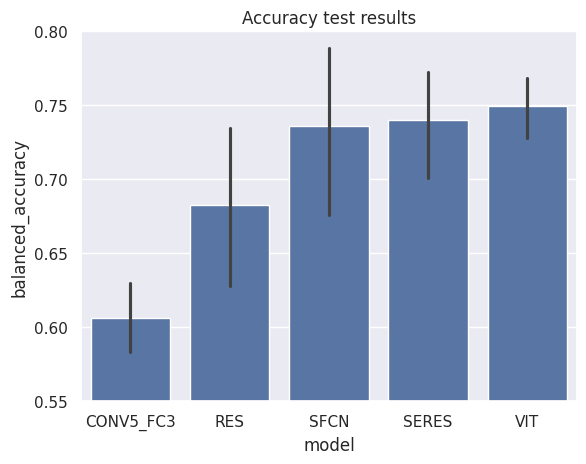

In [148]:
sb.barplot(simple_scratch, x="model", y="balanced_accuracy", order=[
    'CONV5_FC3', 'RES',  'SFCN', 'SERES','VIT',
])
plt.ylim((0.55,0.8))
plt.title("Accuracy test results")

In [15]:
to_report = simple_scratch.sort_values("balanced_accuracy", ascending=False).iloc[:5]
to_report = to_report.drop(columns='source')
print(to_report.to_latex(escape=True, index=False,  float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
model & run\_num & balanced\_accuracy & f1\_0 & f1\_1 & f1\_2 \\
\midrule
SFCN & 2 & 0.796 & 0.783 & 0.667 & 0.914 \\
SFCN & 5 & 0.786 & 0.792 & 0.550 & 0.918 \\
SERES & 2 & 0.783 & 0.816 & 0.571 & 0.897 \\
VIT & 5 & 0.780 & 0.791 & 0.638 & 0.909 \\
SERES & 3 & 0.778 & 0.833 & 0.550 & 0.889 \\
\bottomrule
\end{tabular}



### Confidence analysis

,model,task,run_num,source,balanced_accuracy,kept_proportion
0,RES,MOTION,2,conf-95,0.666667,0.629213
1,RES,MOTION,2,conf-99,0.666667,0.438202
2,CONV5_FC3,SSIM,2,conf-95,0.666667,0.280899
3,CONV5_FC3,SSIM,2,conf-99,0.500000,0.179775
4,SERES,BINARY,1,conf-95,1.000000,0.101124
...,...,...,...,...,...,...
0,RES,BINARY,2,simple,0.683830,1.000000
0,SFCN,BINARY,4,simple,0.746032,1.000000
0,RES,SSIM,5,simple,0.737730,1.000000
0,RES,MOTION,3,simple,0.749172,1.000000


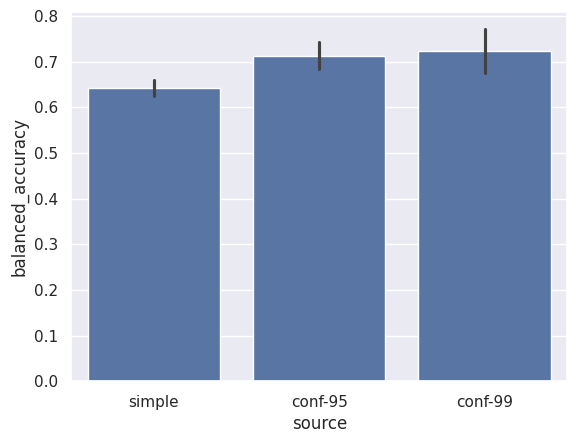

In [162]:
sb.barplot(conf_results, x='source', y='balanced_accuracy', order=('simple', 'conf-95', 'conf-99'))
conf_results

(0, model                     RES
task                   MOTION
run_num                     2
source                conf-95
balanced_accuracy    0.666667
kept_proportion      0.629213
Name: 0, dtype: object)


TypeError: tuple indices must be integers or slices, not str

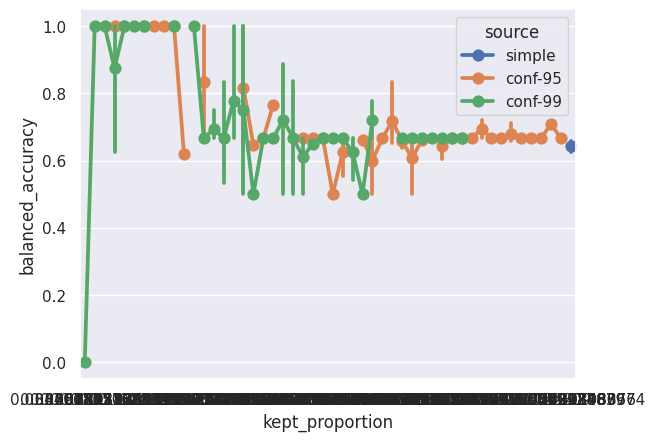

In [160]:
sb.pointplot(conf_results, x='kept_proportion', y='balanced_accuracy', hue="source", hue_order=('simple', 'conf-95', 'conf-99'))
for row in conf_results.groupby("").iterrows():
    print(row)
    colors = {
        'simple':'-r',
        'conf-95':'-b',
        'conf-99':'-g',
    }
    plt.plot(row["balanced_accuracy"], row['kept_proportion'], color=colors[row['source']])

In [17]:
conf_agg = conf_results.groupby(["model", "source"], as_index=True).agg(['mean', 'std', 'max'])
conf_agg=conf_agg.drop(columns='run_num')

conf_agg.columns = ['_'.join(col).strip().strip("_") for col in conf_agg.columns.values]
conf_agg['Balanced Accuracy (mean ± std)'] = conf_agg['balanced_accuracy_mean'].round(3).astype(str) + ' ± ' + conf_agg['balanced_accuracy_std'].round(3).astype(str)
conf_agg['Kept Proportion (mean ± std)'] = conf_agg['kept_proportion_mean'].round(3).astype(str) + ' ± ' + conf_agg['kept_proportion_std'].round(3).astype(str)

print(conf_agg.to_latex(escape=True, multirow=True,  float_format="%.3f", columns=['Balanced Accuracy (mean ± std)', 'Kept Proportion (mean ± std)']))

\begin{tabular}{llll}
\toprule
 &  & Balanced Accuracy (mean ± std) & Kept Proportion (mean ± std) \\
model & source &  &  \\
\midrule
\multirow[t]{3}{*}{CONV5\_FC3} & conf-95 & 0.833 ± 0.236 & 0.272 ± 0.047 \\
 & conf-99 & 0.9 ± 0.224 & 0.178 ± 0.057 \\
 & simple & 0.606 ± 0.031 & 1.0 ± 0.0 \\
\cline{1-4}
\multirow[t]{3}{*}{RES} & conf-95 & 0.767 ± 0.224 & 0.306 ± 0.073 \\
 & conf-99 & 0.9 ± 0.224 & 0.222 ± 0.1 \\
 & simple & 0.683 ± 0.07 & 1.0 ± 0.0 \\
\cline{1-4}
\multirow[t]{3}{*}{SERES} & conf-95 & 0.667 ± 0.0 & 0.456 ± 0.06 \\
 & conf-99 & 0.867 ± 0.183 & 0.375 ± 0.051 \\
 & simple & 0.74 ± 0.048 & 1.0 ± 0.0 \\
\cline{1-4}
\multirow[t]{3}{*}{SFCN} & conf-95 & 0.633 ± 0.217 & 0.301 ± 0.083 \\
 & conf-99 & 0.8 ± 0.274 & 0.184 ± 0.082 \\
 & simple & 0.736 ± 0.073 & 1.0 ± 0.0 \\
\cline{1-4}
\multirow[t]{3}{*}{VIT} & conf-95 & 0.561 ± 0.135 & 0.699 ± 0.124 \\
 & conf-99 & 0.575 ± 0.058 & 0.638 ± 0.109 \\
 & simple & 0.749 ± 0.027 & 1.0 ± 0.0 \\
\cline{1-4}
\bottomrule
\end{tabular}



## Transfer Learning

In [152]:
full_results = []
conf_results = []
for models_directory in glob.glob(path.join(path_to_test,"transfer", "*")):
    model, task, run_num = path.basename(models_directory).split("-")

    results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
    results['model']=model
    results['task']=task
    results['run_num']=int(run_num)

    conf_df = pd.read_csv(path.join(models_directory, "confidence.csv"))
    row_95 = conf_df[conf_df['threshold_confidence']>0.949].iloc[0]
    conf_results.append([model, task, int(run_num), 'conf-95',row_95['balanced_accuracy'], row_95['kept_proportion']])
    row_99 = conf_df[conf_df['threshold_confidence']>0.989].iloc[0]
    conf_results.append([model, task, int(run_num), 'conf-99',row_99['balanced_accuracy'], row_99['kept_proportion']])

    full_results.append(results[['model', "task", 'run_num', 'source','balanced_accuracy','f1_0','f1_1','f1_2']])

full_results =pd.concat(full_results)
transfer_averaged_res = full_results.groupby(["model",'task', "source"], as_index=False).agg(['mean', 'std', 'max'])
transfer_averaged_res.columns = ['_'.join(col).strip().strip("_") for col in transfer_averaged_res.columns.values]
transfer_simple_results = full_results[full_results['source']=='simple']

conf_results = pd.DataFrame(conf_results, columns=['model', "task", 'run_num', 'source','balanced_accuracy','kept_proportion'])
full_results['kept_proportion']=1
conf_results = pd.concat([conf_results,full_results[['model', "task", 'run_num', 'source','balanced_accuracy','kept_proportion']]])
conf_results = conf_results[conf_results['source']!='mcdropout']


exps = api.get_experiments('mrart', 'estimate-motion-pretrain', 'transfer*')
# transfer_ressources_df = get_compute_usage_df(exps, task_dependent=True)
conf_results

,model,task,run_num,source,balanced_accuracy,kept_proportion
0,RES,MOTION,2,conf-95,0.666667,0.629213
1,RES,MOTION,2,conf-99,0.666667,0.438202
2,CONV5_FC3,SSIM,2,conf-95,0.666667,0.280899
3,CONV5_FC3,SSIM,2,conf-99,0.500000,0.179775
4,SERES,BINARY,1,conf-95,1.000000,0.101124
...,...,...,...,...,...,...
0,RES,BINARY,2,simple,0.683830,1.000000
0,SFCN,BINARY,4,simple,0.746032,1.000000
0,RES,SSIM,5,simple,0.737730,1.000000
0,RES,MOTION,3,simple,0.749172,1.000000


Text(0.5, 1.0, 'Transfer Accuracy test results')

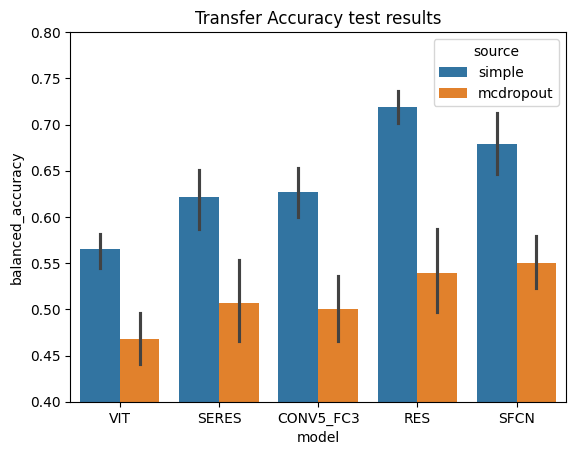

In [20]:
sb.barplot(full_results.sort_values("balanced_accuracy"), x="model", hue="source", y="balanced_accuracy", hue_order=('simple', 'mcdropout'))
plt.ylim((0.4,0.8))
plt.title("Transfer Accuracy test results")

Text(0.5, 1.0, 'Average Balanced Accuracy By Task for Transfer Models')

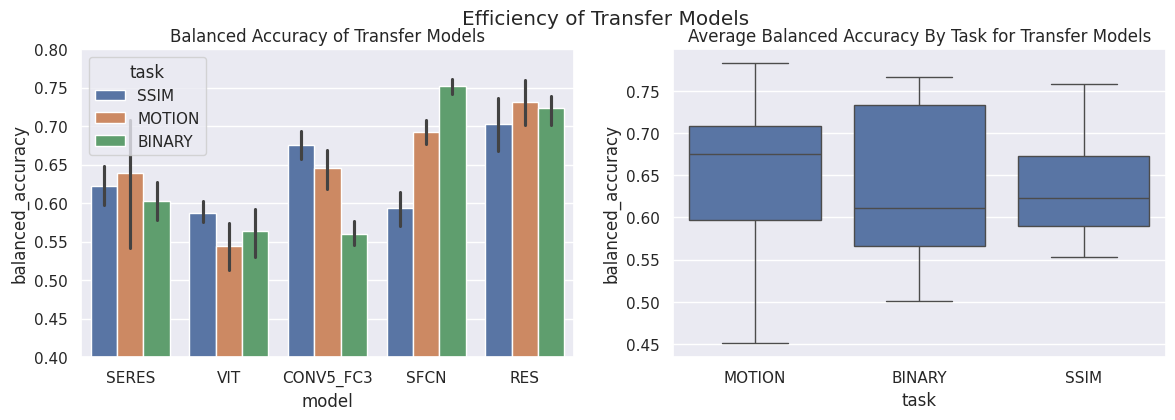

In [149]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("Efficiency of Transfer Models")
plt.subplot(1,2,1)
sb.barplot(transfer_simple_results.sort_values("balanced_accuracy"), x="model", y="balanced_accuracy", hue="task", hue_order=task_hue_order)
plt.ylim((0.4,0.8))
plt.title("Balanced Accuracy of Transfer Models")

plt.subplot(1,2,2)
sb.boxplot(transfer_simple_results.sort_values("balanced_accuracy"), x="task",  y="balanced_accuracy")
# plt.ylim((0.6,0.7))
plt.title("Average Balanced Accuracy By Task for Transfer Models")

In [22]:
to_report = transfer_simple_results.sort_values("balanced_accuracy", ascending=False).iloc[:5]
to_report = to_report.drop(columns='source')
print(to_report.to_latex(escape=True, index=False,  float_format="%.3f"))

\begin{tabular}{llrrrrr}
\toprule
model & task & run\_num & balanced\_accuracy & f1\_0 & f1\_1 & f1\_2 \\
\midrule
RES & MOTION & 1 & 0.783 & 0.816 & 0.571 & 0.897 \\
SFCN & BINARY & 3 & 0.766 & 0.769 & 0.545 & 0.902 \\
RES & SSIM & 4 & 0.758 & 0.764 & 0.545 & 0.861 \\
SFCN & BINARY & 5 & 0.758 & 0.824 & 0.488 & 0.860 \\
SFCN & BINARY & 1 & 0.757 & 0.808 & 0.444 & 0.889 \\
\bottomrule
\end{tabular}



### Confidence Analysis

<Axes: xlabel='source', ylabel='balanced_accuracy'>

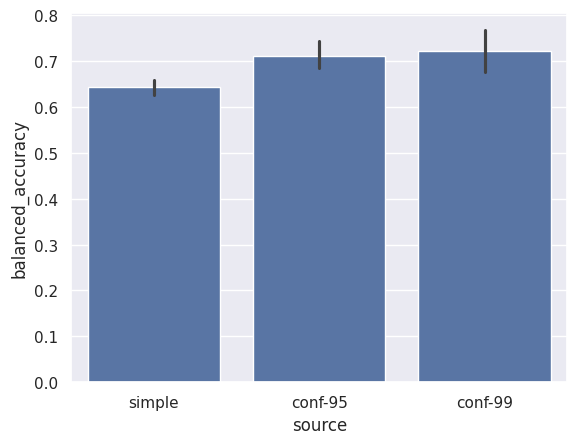

In [153]:
sb.barplot(conf_results, x='source', y='balanced_accuracy', order=('simple', 'conf-95', 'conf-99'))

In [273]:
conf_agg = conf_results.groupby(["model",'task', "source"], as_index=True).agg(['mean', 'std', 'max'])
conf_agg=conf_agg.drop(columns='run_num')

conf_agg.columns = ['_'.join(col).strip().strip("_") for col in conf_agg.columns.values]
conf_agg['Balanced Accuracy (mean ± std)'] = conf_agg['balanced_accuracy_mean'].round(3).astype(str) + ' ± ' + conf_agg['balanced_accuracy_std'].round(3).astype(str)
conf_agg['Kept Proportion (mean ± std)'] = conf_agg['kept_proportion_mean'].round(3).astype(str) + ' ± ' + conf_agg['kept_proportion_std'].round(3).astype(str)

print(conf_agg.to_latex(escape=True, multirow=True,  float_format="%.3f", columns=['Balanced Accuracy (mean ± std)', 'Kept Proportion (mean ± std)']))

\begin{tabular}{lllll}
\toprule
 &  &  & Balanced Accuracy (mean ± std) & Kept Proportion (mean ± std) \\
model & task & source &  &  \\
\midrule
\multirow[t]{9}{*}{CONV5\_FC3} & \multirow[t]{3}{*}{BINARY} & conf-95 & 0.85 ± 0.205 & 0.13 ± 0.044 \\
 &  & conf-99 & 1.0 ± 0.0 & 0.049 ± 0.013 \\
 &  & simple & 0.56 ± 0.022 & 1.0 ± 0.0 \\
\cline{2-5}
 & \multirow[t]{3}{*}{MOTION} & conf-95 & 0.56 ± 0.089 & 0.335 ± 0.089 \\
 &  & conf-99 & 0.833 ± 0.236 & 0.209 ± 0.121 \\
 &  & simple & 0.646 ± 0.033 & 1.0 ± 0.0 \\
\cline{2-5}
 & \multirow[t]{3}{*}{SSIM} & conf-95 & 0.633 ± 0.075 & 0.384 ± 0.075 \\
 &  & conf-99 & 0.6 ± 0.091 & 0.249 ± 0.044 \\
 &  & simple & 0.676 ± 0.024 & 1.0 ± 0.0 \\
\cline{1-5} \cline{2-5}
\multirow[t]{9}{*}{RES} & \multirow[t]{3}{*}{BINARY} & conf-95 & 0.667 ± 0.0 & 0.333 ± 0.07 \\
 &  & conf-99 & 0.7 ± 0.183 & 0.137 ± 0.05 \\
 &  & simple & 0.723 ± 0.023 & 1.0 ± 0.0 \\
\cline{2-5}
 & \multirow[t]{3}{*}{MOTION} & conf-95 & 0.665 ± 0.004 & 0.535 ± 0.083 \\
 &  & conf-9

## Ressource usage comparison Scratch vs Transfer

In [249]:
tsf_res_agg =transfer_ressources_df.drop(columns=['duration', 'hours', 'minutes', 'task']).groupby(['model']).agg("mean")
tsf_res_agg['duration']=tsf_res_agg['millis'].apply(lambda x: ':'.join(map(str,ms_to_time(x))))
tsf_res_agg.drop(columns='millis')
print(tsf_res_agg.to_latex(escape=True,  float_format="%.2f"))

\begin{tabular}{lrrl}
\toprule
 & max\_gpu\_ram\_used & max\_gpu\_power\_usage & duration \\
model &  &  &  \\
\midrule
CONV5\_FC3 & 1.48 & 61.06 & 0:17 \\
RES & 1.28 & 61.41 & 0:14 \\
SERES & 1.28 & 60.38 & 0:18 \\
SFCN & 1.28 & 62.03 & 0:16 \\
VIT & 2.61 & 77.62 & 0:25 \\
\bottomrule
\end{tabular}



In [251]:
scr_res_agg =scratch_ressources_df.drop(columns=['duration', 'hours', 'minutes']).groupby(['model']).agg("mean")
scr_res_agg['duration']=scr_res_agg['millis'].apply(lambda x: ':'.join(map(lambda x:str(x).zfill(2),ms_to_time(x))))
scr_res_agg=scr_res_agg.drop(columns='millis')
print(scr_res_agg.to_latex(escape=True,  float_format="%.2f"))

\begin{tabular}{lrrl}
\toprule
 & max\_gpu\_ram\_used & max\_gpu\_power\_usage & duration \\
model &  &  &  \\
\midrule
CONV5\_FC3 & 10.14 & 285.31 & 00:19 \\
RES & 15.92 & 329.08 & 01:04 \\
SERES & 17.36 & 329.44 & 01:17 \\
SFCN & 30.85 & 385.64 & 01:13 \\
VIT & 36.81 & 390.68 & 00:42 \\
\bottomrule
\end{tabular}



## Table Comparison of Experiments

In [262]:
thresh_res = thresh_mrart_results.sort_values("balanced_accuracy", ascending=False)
thresh_res['from'] = "Threshold Pretrain"
thresh_res['balanced_accuracy_max']=thresh_res['balanced_accuracy']
thresh_res['balanced_accuracy']='-'
thresh_res['name']=thresh_res['model'] + ' - ' +thresh_res['task']

transfer_res = transfer_averaged_res[transfer_averaged_res['source']=='simple'].sort_values("balanced_accuracy_max", ascending=False)
transfer_res['from'] = "Transfer learning"
transfer_res['balanced_accuracy']=transfer_res['balanced_accuracy_mean'].round(3).astype(str) + ' ± ' + transfer_res['balanced_accuracy_std'].round(3).astype(str)
transfer_res['name']=transfer_res['model'] + ' - ' +transfer_res['task']


scratch_res = scratch_averaged_res[scratch_averaged_res['source']=='simple'].sort_values("balanced_accuracy_max", ascending=False)
scratch_res['from']="Train from Scratch"
scratch_res['balanced_accuracy']=scratch_res['balanced_accuracy_mean'].round(3).astype(str) + ' ± ' + scratch_res['balanced_accuracy_std'].round(3).astype(str) 
scratch_res['name']=scratch_res['model']

final_select = ['name','from', "balanced_accuracy_max", 'balanced_accuracy']
final = pd.concat([thresh_res[final_select], transfer_res[final_select], scratch_res[final_select]])
print(final.to_latex(index=False, escape=True, float_format="%.3f"))


\begin{tabular}{llll}
\toprule
name & from & balanced\_accuracy\_max & balanced\_accuracy \\
\midrule
SFCN - SSIM & Threshold Pretrain & 0.684 & - \\
SFCN - MOTION & Threshold Pretrain & 0.67 & - \\
CONV5\_FC3 - MOTION & Threshold Pretrain & 0.612 & - \\
RES - MOTION & Threshold Pretrain & 0.597 & - \\
CONV5\_FC3 - SSIM & Threshold Pretrain & 0.587 & - \\
RES - SSIM & Threshold Pretrain & 0.586 & - \\
SERES - MOTION & Threshold Pretrain & 0.585 & - \\
SERES - SSIM & Threshold Pretrain & 0.573 & - \\
VIT - MOTION & Threshold Pretrain & 0.56 & - \\
CONV5\_FC3 - BINARY & Threshold Pretrain & 0.519 & - \\
VIT - BINARY & Threshold Pretrain & 0.517 & - \\
VIT - SSIM & Threshold Pretrain & 0.466 & - \\
SERES - BINARY & Threshold Pretrain & 0.347 & - \\
SFCN - BINARY & Threshold Pretrain & 0.333 & - \\
RES - BINARY & Threshold Pretrain & 0.254 & - \\
RES - MOTION & Transfer learning & 0.783 & 0.731 ± 0.04 \\
SFCN - BINARY & Transfer learning & 0.766 & 0.752 ± 0.013 \\
RES - SSIM & Transfer lea

# Unbalanced Dataset Test

## Threshold

In [118]:

umrart_results=[]
for models_directory in glob.glob(path.join(path_to_test,"ubalanced","pretrain", "*")):
    model, task, *_ = path.basename(models_directory).split("-")

    umrart = pd.read_csv(path.join(models_directory, 'unbalanced-mrart_recap.csv'))
    umrart['model']=model
    umrart['task']=task
    umrart_results.append(umrart[['model', 'task', 'balanced_accuracy','threshold_1','threshold_2','f1_0','f1_1','f1_2']])

thresh_umrart_results =pd.concat(umrart_results)
thresh_umrart_results.sort_values("balanced_accuracy", ascending=False)

,model,task,balanced_accuracy,threshold_1,threshold_2,f1_0,f1_1,f1_2
0,SFCN,SSIM,0.648467,0.035578,0.048065,0.750000,0.400000,0.781250
0,CONV5_FC3,MOTION,0.586973,0.871291,1.046529,0.600000,0.333333,0.827586
0,SFCN,MOTION,0.586590,0.858482,0.908578,0.711111,0.214286,0.754098
0,SERES,MOTION,0.578416,0.614998,1.123020,0.470588,0.488889,0.763636
0,SERES,SSIM,0.560345,0.014819,0.025874,0.344828,0.461538,0.818182
0,CONV5_FC3,SSIM,0.538442,0.036796,0.043230,0.500000,0.320000,0.754098
0,RES,SSIM,0.514432,0.019194,0.027303,0.428571,0.357143,0.717949
0,RES,BINARY,0.506130,0.030299,0.381770,0.428571,0.480000,0.571429
0,VIT,SSIM,0.502810,-0.000179,0.000876,0.583333,0.235294,0.653846
0,VIT,MOTION,0.487292,0.084462,0.214945,0.511628,0.210526,0.754717


Text(0.5, 1.0, 'Average Balanced Accuracy By Task for Threshold Models')

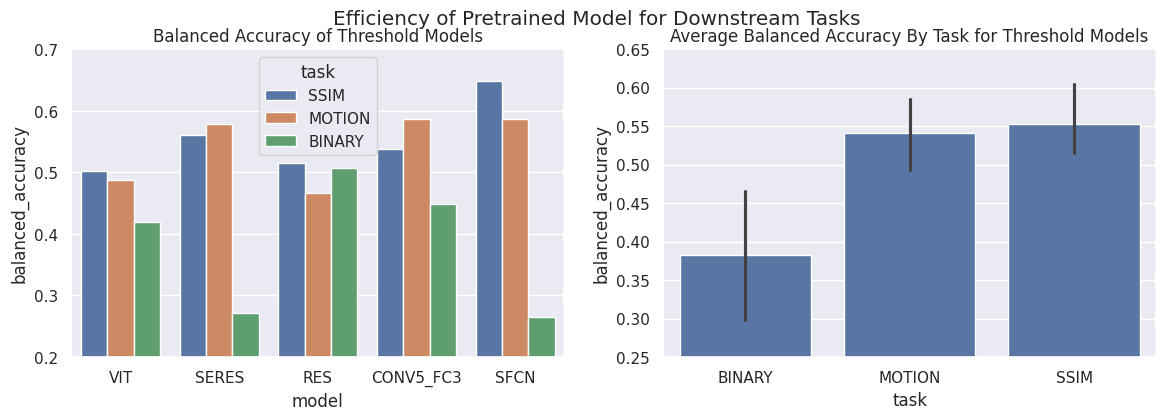

In [117]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("Efficiency of Pretrained Model for Downstream Tasks")
plt.subplot(1,2,1)
sb.barplot(thresh_umrart_results, x="model", y="balanced_accuracy", hue="task", hue_order=task_hue_order, order=[
   'VIT',    'SERES','RES','CONV5_FC3', 'SFCN',
])
plt.ylim((0.2,0.7))
plt.title("Balanced Accuracy of Threshold Models")

plt.subplot(1,2,2)
sb.barplot(thresh_umrart_results.sort_values("balanced_accuracy"), x="task",  y="balanced_accuracy")
plt.ylim((0.25,0.65))
plt.title("Average Balanced Accuracy By Task for Threshold Models")

<Axes: xlabel='balanced_accuracy'>

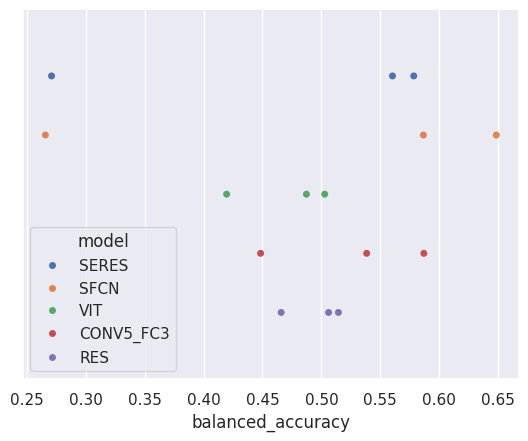

In [143]:
sb.swarmplot(thresh_umrart_results, x='balanced_accuracy', hue='model', dodge=True)

## Scratch

In [121]:
full_results = []
for models_directory in glob.glob(path.join(path_to_test,"ubalanced", "scratch", "*")):
    model, run_num = path.basename(models_directory).removesuffix('.ckpt').split("-")

    results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
    results['model']=model
    results['run_num']=int(run_num)

    full_results.append(results[['model', 'run_num','source','balanced_accuracy','f1_0','f1_1','f1_2']])

full_results =pd.concat(full_results)
uscratch_averaged_res = full_results.groupby(["model","source"], as_index=False).agg(['mean', 'std', 'max'])
uscratch_averaged_res.columns = ['_'.join(col).strip().strip("_") for col in uscratch_averaged_res.columns.values]
usimple_scratch = full_results[full_results['source']=='simple']
usimple_scratch.sort_values("balanced_accuracy", ascending=False)


,model,run_num,source,balanced_accuracy,f1_0,f1_1,f1_2
0,VIT,1,simple,0.584291,0.701754,0.206897,0.708333
0,VIT,4,simple,0.572797,0.645161,0.222222,0.711111
0,SFCN,1,simple,0.552874,0.679245,0.000000,0.698413
0,VIT,5,simple,0.540166,0.666667,0.228571,0.619048
0,VIT,3,simple,0.508301,0.588235,0.160000,0.585366
0,VIT,2,simple,0.448276,0.519481,0.000000,0.512821
0,SFCN,4,simple,0.418391,0.500000,0.000000,0.558824
0,SFCN,5,simple,0.402874,0.461538,0.000000,0.571429
0,CONV5_FC3,1,simple,0.379630,0.441176,0.378378,0.000000
0,RES,5,simple,0.344828,0.465116,0.000000,0.066667


Text(0.5, 1.0, 'Accuracy test results')

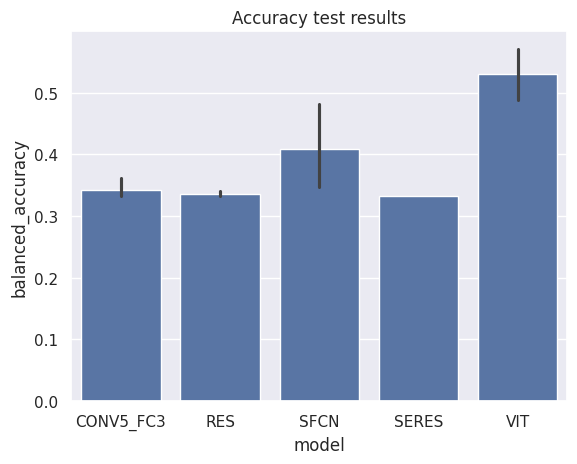

In [120]:
sb.barplot(usimple_scratch, x="model", y="balanced_accuracy", order=[
    'CONV5_FC3', 'RES',  'SFCN', 'SERES','VIT',
])
# plt.ylim((0.3,0.8))
plt.title("Accuracy test results")

<Axes: xlabel='balanced_accuracy'>

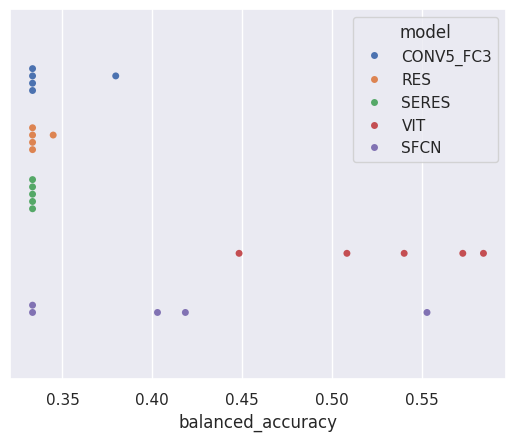

In [140]:
sb.swarmplot(usimple_scratch, x='balanced_accuracy', hue='model', dodge=True)

## Transfer

In [122]:
full_results = []
for models_directory in glob.glob(path.join(path_to_test,"ubalanced", "transfer", "*")):
    model, task, run_num = path.basename(models_directory).split("-")

    results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
    results['model']=model
    results['task']=task
    results['run_num']=int(run_num)

    full_results.append(results[['model', "task", 'run_num', 'source','balanced_accuracy','f1_0','f1_1','f1_2']])

full_results =pd.concat(full_results)
utransfer_averaged_res = full_results.groupby(["model",'task', "source"], as_index=False).agg(['mean', 'std', 'max'])
utransfer_averaged_res.columns = ['_'.join(col).strip().strip("_") for col in utransfer_averaged_res.columns.values]
utransfer_simple_results = full_results[full_results['source']=='simple']

Text(0.5, 1.0, 'Average Balanced Accuracy By Task for Transfer Models')

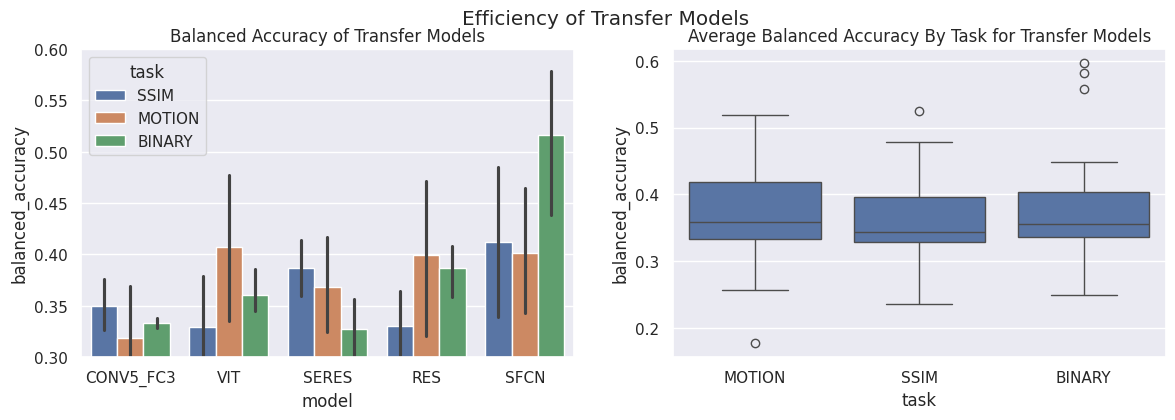

In [124]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("Efficiency of Transfer Models")
plt.subplot(1,2,1)
sb.barplot(utransfer_simple_results.sort_values("balanced_accuracy"), x="model", y="balanced_accuracy", hue="task", hue_order=task_hue_order)
plt.ylim((0.3,0.6))
plt.title("Balanced Accuracy of Transfer Models")

plt.subplot(1,2,2)
sb.boxplot(utransfer_simple_results.sort_values("balanced_accuracy"), x="task",  y="balanced_accuracy")
# plt.ylim((0.6,0.7))
plt.title("Average Balanced Accuracy By Task for Transfer Models")

<Axes: xlabel='balanced_accuracy'>

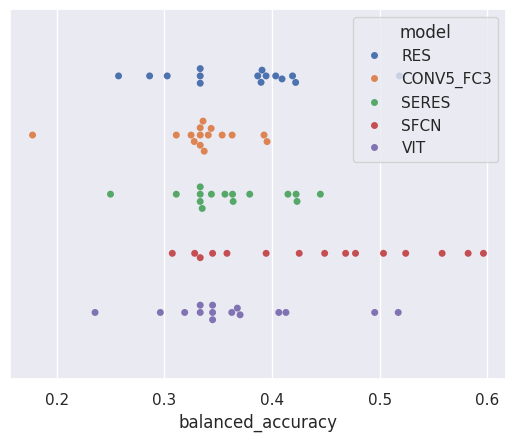

In [141]:
sb.swarmplot(utransfer_simple_results, x='balanced_accuracy', hue='model', dodge=True)

## Unbalanced comparaison

In [125]:
thresh_res = thresh_umrart_results.sort_values("balanced_accuracy", ascending=False)
thresh_res['from'] = "Threshold Pretrain"
thresh_res['balanced_accuracy_max']=thresh_res['balanced_accuracy']
thresh_res['balanced_accuracy']='-'
thresh_res['name']=thresh_res['model'] + ' - ' +thresh_res['task']

transfer_res = utransfer_averaged_res[utransfer_averaged_res['source']=='simple'].sort_values("balanced_accuracy_max", ascending=False)
transfer_res['from'] = "Transfer learning"
transfer_res['balanced_accuracy']=transfer_res['balanced_accuracy_mean'].round(3).astype(str) + ' ± ' + transfer_res['balanced_accuracy_std'].round(3).astype(str)
transfer_res['name']=transfer_res['model'] + ' - ' +transfer_res['task']


scratch_res = uscratch_averaged_res[uscratch_averaged_res['source']=='simple'].sort_values("balanced_accuracy_max", ascending=False)
scratch_res['from']="Train from Scratch"
scratch_res['balanced_accuracy']=scratch_res['balanced_accuracy_mean'].round(3).astype(str) + ' ± ' + scratch_res['balanced_accuracy_std'].round(3).astype(str) 
scratch_res['name']=scratch_res['model']

final_select = ['name','from', "balanced_accuracy_max", 'balanced_accuracy']
final = pd.concat([thresh_res[final_select], transfer_res[final_select], scratch_res[final_select]])
print(final.to_latex(index=False, escape=True, float_format="%.3f"))


\begin{tabular}{llrl}
\toprule
name & from & balanced\_accuracy\_max & balanced\_accuracy \\
\midrule
SFCN - SSIM & Threshold Pretrain & 0.648 & - \\
CONV5\_FC3 - MOTION & Threshold Pretrain & 0.587 & - \\
SFCN - MOTION & Threshold Pretrain & 0.587 & - \\
SERES - MOTION & Threshold Pretrain & 0.578 & - \\
SERES - SSIM & Threshold Pretrain & 0.560 & - \\
CONV5\_FC3 - SSIM & Threshold Pretrain & 0.538 & - \\
RES - SSIM & Threshold Pretrain & 0.514 & - \\
RES - BINARY & Threshold Pretrain & 0.506 & - \\
VIT - SSIM & Threshold Pretrain & 0.503 & - \\
VIT - MOTION & Threshold Pretrain & 0.487 & - \\
RES - MOTION & Threshold Pretrain & 0.466 & - \\
CONV5\_FC3 - BINARY & Threshold Pretrain & 0.448 & - \\
VIT - BINARY & Threshold Pretrain & 0.420 & - \\
SERES - BINARY & Threshold Pretrain & 0.271 & - \\
SFCN - BINARY & Threshold Pretrain & 0.266 & - \\
SFCN - BINARY & Transfer learning & 0.596 & 0.516 ± 0.089 \\
SFCN - SSIM & Transfer learning & 0.524 & 0.413 ± 0.094 \\
RES - MOTION & Transfer

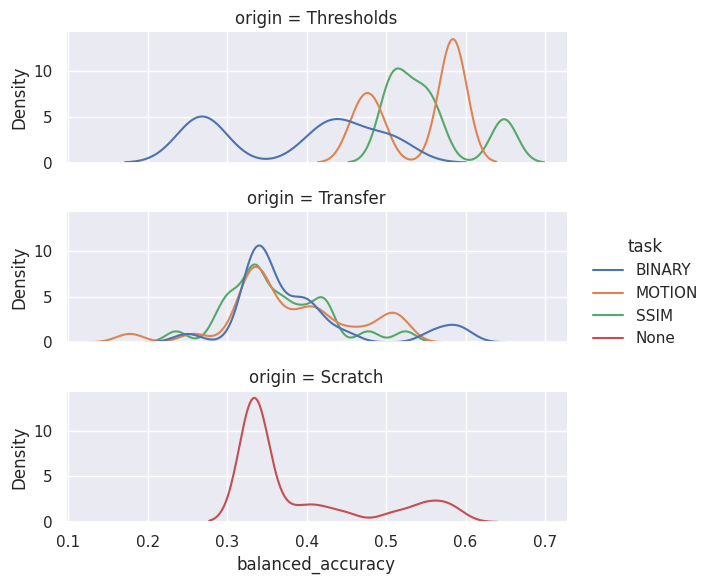

In [139]:
sb.displot(full_res,kind="kde", x="balanced_accuracy",   row='origin', hue='task',  height=2, aspect=3, common_norm=False, bw_adjust=0.4)

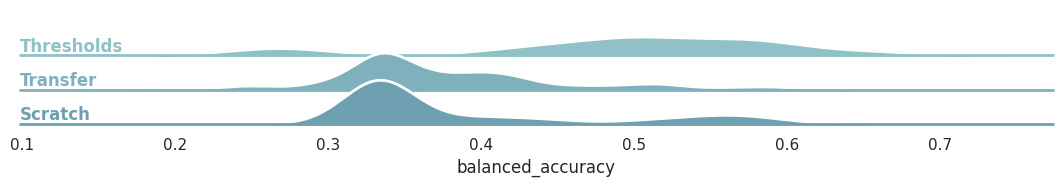

In [137]:
sb.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sb.cubehelix_palette(10, rot=-.25, light=.7)
g = sb.FacetGrid(full_res, row="origin", hue="origin", aspect=15, height=0.75, palette=pal)

# Draw the densities in a few steps
g.map(sb.kdeplot, "balanced_accuracy",
      bw_adjust=0.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sb.kdeplot, "balanced_accuracy", clip_on=False, color="w", lw=2, bw_adjust=0.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "balanced_accuracy")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
sb.set_theme()

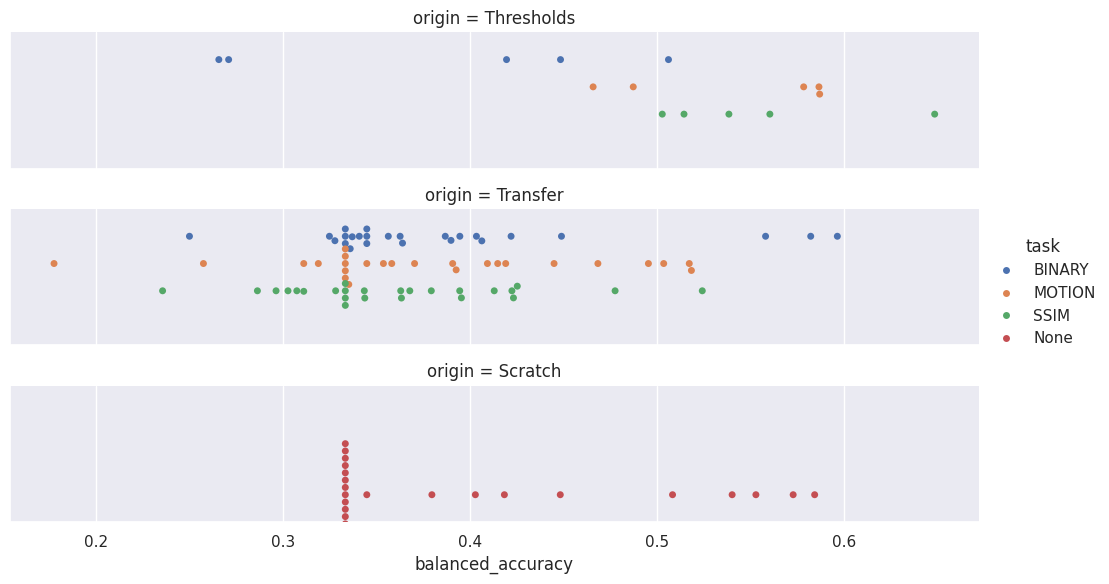

In [138]:
sb.catplot(full_res,kind='swarm', x="balanced_accuracy",   row='origin', hue='task',  height=2, aspect=5, dodge=True)